# Spectroscopic factors

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ November 1, 2022

This notebook serves as a testbed for calculating spectroscopic factors using mean field approximations for initial and final states and applying SRG transformations to the operator. The normalization of spectroscopic overlaps give relative spectroscopic factors.

_Last update:_ January 24, 2023

__To-do list:__
* Thoroughly update docstrings.
* This method only requires the occupied bound states. Re-code the `SingleParticleBasis` class if this works, and consider using `HFBRAD` code again.
* Move functions and classes into scripts once you've settled on how to compute things.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn, sph_harm
import shutil
from sympy.physics.quantum.cg import CG
import time
import vegas

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_nucleus
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import convert_l_to_string, coupled_channel
from scripts.woodsaxon import ws

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

## Classes

In [5]:
class SingleParticleState:
    
    
    def __init__(self, n, l, j, m_j, tau):
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.tau = tau
        if tau == 1/2:
            self.nucleon = 'proton'
        elif tau == -1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):
        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.tau == sp_state.tau
        ):
            return True
        else:
            return False
        
        
    def __str__(self):
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [6]:
class SingleParticleBasis:
    """
    Single-particle basis class. Handles the wave functions associated with the
    Wood-Saxon potential from the subroutine in woodsaxon.f90. Generates wave
    functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    
    def __init__(self, nucleus_name, Z, N, n_max, l_max, rmax=40, ntab=2000):

        # Generate orbitals
        self.run_wood_saxon_code(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
                
        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Move output files to relevant directory
        wood_saxon_directory = f"../data/wood_saxon/{nucleus_name}/"
        shutil.move("ws_log", wood_saxon_directory + "ws_log")
        shutil.move("ws_pot", wood_saxon_directory + "ws_pot")
        shutil.move("ws_rho", wood_saxon_directory + "ws_rho")

        # Move orbital files and organize wave functions in dictionary with
        # the file name as the key
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                file_name = self.get_orbital_file_name(sp_state)
                shutil.move(file_name, wood_saxon_directory + file_name)
                data = np.loadtxt(wood_saxon_directory + file_name)
                # Use file name as the key
                self.sp_wfs[file_name] = data[:, 1]

            
    def run_wood_saxon_code(
            self, nucleus_name, Z, N, n_max, l_max, rmax, ntab):
        """Run Wood-Saxon code to generate data."""
        
        # Total number of nucleons
        A = Z + N
        
        # Type of orbitals: 1 - nucleons with no Coulomb
        #                   2 - distinguish protons and neutrons
        ntau = 2
        
        # Orbitals to consider (note, we track 2*j not j)
        norb, lorb, jorb = [], [], []
        for n in range(1, n_max+1):
            for l in range(0, l_max+1):
                norb.append(n)
                lorb.append(l)
                jorb.append(int(2*(l+1/2)))
                if int(2*(l-1/2)) > 0:  # Don't append negative j
                    norb.append(n)
                    lorb.append(l)
                    jorb.append(int(2*(l-1/2)))
        nrad = len(jorb)
        orbws = np.zeros(shape=(2,nrad,ntab), order='F')
    
        # Divide orbital by r? -> get R(r); false: get u(r)=r R(r)
        rdiv = False
        dens = True
    
        # Set parameters of the Wood-Saxon potential
        prm = np.zeros(shape=(2,9), order='F')
    
        # Starting with vws (p & n)
        if nucleus_name == 'He4':
            prm[:,0] = 76.8412
            # prm[:,0] = 90.0  # For bound 1p_{1/2} state
        elif nucleus_name == 'O16':
            prm[:,0] = 58.0611
        elif nucleus_name == 'Ca40':
            prm[:,0] = 54.3051
        elif nucleus_name == 'Ca48':
            prm[0,0] = 59.4522
            prm[1,0] = 46.9322
    
        # Not sure about these (better way to load these parameters?)
        prm[:,1] = 1.275
        prm[:,2] = 0.7
        prm[:,3] = 0.
        prm[:,4] = 1.
        prm[:,5] = 36
        prm[:,6] = 1.32
        prm[:,7] = 0.7
        prm[:,8] = 1.275
        
        # Print summary, potentials, and densities
        prnt = True
        prntorb = True

        # Run Fortran subroutine
        ws(ntau, A, Z, rmax, orbws, norb, lorb, jorb, prm, rdiv, prnt, prntorb,
           dens)

        # Set radial distance array and step-size as instance attributes
        self.dr = rmax / ntab
        self.r_array = np.arange(self.dr, rmax + self.dr, self.dr)
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []
        self.occ_states = []
        proton_count = 0
        neutron_count = 0
    
        # Order single-particle states using the ws_log file
        with open('ws_log', 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, \tau
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occ_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, \tau
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occ_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1
                        
                        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
        
        n, l, j = sp_state.n, sp_state.l, sp_state.j
        # Proton
        if sp_state.tau == 1/2:
            file_name = f"p.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
        # Neutron
        elif sp_state.tau == -1/2:
            file_name = f"n.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
        
        return file_name
                        
    
    def get_wf_rspace(self, sp_state, print_normalization=False):
        """Single-particle wave function in coordinate space."""
        
        # Orbital file name is the key
        u_array = self.sp_wfs[self.get_orbital_file_name(sp_state)]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr*u_array**2)
            print(f"Coordinate space normalization = {normalization}.")

        return self.r_array, u_array
    
    
    def fourier_transformation(self, l, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(self.r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j**(-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, print_normalization=False, interpolate=False,
            kmax=15.0, kmid=3.0, ntot=120):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        _, u_array = self.get_wf_rspace(sp_state)

        # Fourier-transform the wave function to momentum space
        phi_array = self.fourier_transformation(sp_state.l, k_array) @ u_array
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights*k_array**2*abs(phi_array)**2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            phi_func = interp1d(k_array, phi_array, kind='linear',
                                bounds_error=False, fill_value='extrapolate')
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array

In [7]:
# Don't worry about saving/loading yet
class SpectroscopicOverlap(SingleParticleBasis):
    """DOCSTRING"""
    
    
    def __init__(
        self, nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax=40,
        ntab=2000, kmax=15.0, kmid=3.0, ntot=120, generator='Wegner',
        lamb=1.35, calculate=False
    ):
        
        # Directory for spectroscopic amplitudes data
        self.directory = f"../data/spectroscopic_amplitudes/{nucleus_name}/"

        if calculate:
            
            # Call SingleParticleBasis super-class
            super().__init__(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
            
            # Set instance attributes
            self.channels = channels
            self.kvnn = kvnn
            self.kmax = kmax
            self.kmid = kmid
            self.ntot = ntot
            self.generator = generator
            self.lamb = lamb
            
            # Set Clebsch-Gordan table with j_max = 4
            self.cg_table = self.set_clebsch_gordan_table(4)
            
            # Spin projections
            self.spins = np.array([1/2, -1/2])
            
            # Set interpolating functions for s.p. wave functions \phi
            self.set_sp_wave_functions()

            # Set interpolating functions for \delta U^\dagger
            self.set_delta_U_dagger_functions()
            
            # Initialize momenta q and its angles
            self.q_array, self.q_weights = momentum_mesh(10.0, 2.0, 80)

        else:
            pass
    
    
    def set_clebsch_gordan_table(self, j_max):
        """
        Calculate Clebsch-Gordan coefficients for all combinations of j and m_j
        up to j_max.
    
        Parameters
        ----------
        j_max : int
            Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
        Returns
        -------
        cg_table : dict
            Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
            for each combination of angular momenta.
        
        """
        
        cg_table = {}
        
        j_array = np.arange(0, j_max+1/2, 1/2)

        for j_1 in j_array:
            for m_1 in np.arange(-j_1, j_1+1, 1):
                for j_2 in j_array:
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        for j_3 in j_array:
                            for m_3 in np.arange(-j_3, j_3+1, 1):
                                cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                    CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                                )
                                
        return cg_table
    
    
    def get_channel_str(self, Lp, L, S, J):
        """Gets the partial wave channel string given quantum numbers."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if Lp == 0:
            Lp_str = 'S'
        elif Lp == 1:
            Lp_str = 'P'
        elif Lp == 2:
            Lp_str = 'D'
        elif Lp == 3:
            Lp_str = 'F'
        elif Lp == 4:
            Lp_str = 'G'
        elif Lp == 5:
            Lp_str = 'H'
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
        
        channel = f"{2*S+1}{Lp_str}{J}"
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        # L = L' if the channel is not coupled
        if channel in ['3S1', '3D1', '3P2', '3F2', '3D3', '3G3']:
        
            if L == 0:
                L_str = 'S'
            elif L == 1:
                L_str = 'P'
            elif L == 2:
                L_str = 'D'
            elif L == 3:
                L_str = 'F'
            elif L == 4:
                L_str = 'G'
            elif L == 5:
                L_str = 'H'
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
            
            channel += f"-{2*S+1}{L_str}{J}"

        return channel
    
    
    def get_channel_quantum_numbers(self, channel):
        """Gets the quantum numbers of a partial wave channel."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if channel[1] == 'S':
            Lp = 0
        elif channel[1] == 'P':
            Lp = 1
        elif channel[1] == 'D':
            Lp = 2
        elif channel[1] == 'F':
            Lp = 3
        elif channel[1] == 'G':
            Lp = 4
        elif channel[1] == 'H':
            Lp = 5
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        if coupled_channel(channel[:3]):
        
            if channel[5] == 'S':
                L = 0
            elif channel[5] == 'P':
                L = 1
            elif channel[5] == 'D':
                L = 2
            elif channel[5] == 'F':
                L = 3
            elif channel[5] == 'G':
                L = 4
            elif channel[5] == 'H':
                L = 5
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
        
        # L = L' if the channel is not coupled
        else:
        
            L = Lp
        
        # Total spin S = 0 or 1
        S = int((int(channel[0])-1)/2)
    
        # Total angular momentum J = 0, 1, 2, ...
        J = int(channel[2])
            
        return Lp, L, S, J
    
    
    def get_total_isospin(self, L, S):
        """Total isospin according to antisymmetry."""
    
        # Make sure [1-(-1)^(L+S+T)] is not zero
        if (1-(-1)**(L+S)) == 0:
            T = 1
        else:
            T = 0
        
        return T
    
    
    def set_sp_wave_functions(self):
        """Save s.p. wave functions to dictionary."""
        
        self.phi_functions = {}
        for sp_state in self.occ_states: 
            file_name = self.get_orbital_file_name(sp_state)
            self.phi_functions[file_name] = self.get_wf_kspace(sp_state,
                                                               interpolate=True)
    
    
    def interpolate_delta_U_dagger(self, channel):
        """Interpolate \delta U^\dagger(k',k) for the given channel."""
    
        # Set channel argument to be compatible with potential functions
        if channel[:3] in ['3S1', '3D1']:
            channel_arg = '3S1'
        elif channel[:3] in ['3P2', '3F2']:
            channel_arg = '3P2'
        elif channel[:3] in ['3D3', '3G3']:
            channel_arg = '3D3'
        else:
            channel_arg = channel[:3]
        
        # Set potential
        potential = Potential(self.kvnn, channel_arg, self.kmax, self.kmid,
                              self.ntot)
    
        # Get momentum mesh
        k_array, k_weights = potential.load_mesh()
    
        # Initial and evolved Hamiltonians
        H_initial = potential.load_hamiltonian()
        if self.generator == 'Block-diag':
            H_evolved = potential.load_hamiltonian('srg', self.generator, 1.0,
                                                   lambda_bd=self.lamb)
        else:
            H_evolved = potential.load_hamiltonian('srg', self.generator,
                                                   self.lamb)
    
        # Get SRG transformation from Hamiltonians
        U_matrix_weights = get_transformation(H_initial, H_evolved)
    
        # Calculate \delta U^\dagger = (U - I)^\dagger
        I_matrix_weights = np.eye(len(U_matrix_weights), len(U_matrix_weights))
        delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T

        # Get specific sub-block if coupled-channel
        n = self.ntot
        if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[:n,n:2*n]
            )
        elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[n:2*n,:n]
            )
        elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[n:2*n,n:2*n]
            )
        else:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[:n,:n]
            )
        
        # Interpolate \delta U^\dagger(k,k')
        delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix)

        return delUdag_func
    
    
    def set_delta_U_dagger_functions(self):
        """Save \delta U^\dagger functions to dictionary."""

        self.delta_U_dagger_functions = {}
        for channel in self.channels:
            self.delta_U_dagger_functions[channel] = (
                self.interpolate_delta_U_dagger(channel)
            )
    
    
    # Fix loops over \sigma and m_l
    def set_quantum_number_sums(self, alpha):
        """Returns all combinations of quantum numbers that give a non-zero
        product of Clebsch-Gordan coefficients in the calculation of the
        \delta U^\dagger term. Use this method to efficiently reorganize the
        sums over quantum numbers.
        """
        
        # Set range of m_l_\alpha values
        m_l_alphas = np.intersect1d(np.arange(-alpha.l, alpha.l+1, 1),
                                    alpha.m_j - self.spins)
    
        # Initialize list to store non-zero combinations of quantum numbers
        combinations = []
        
        # Loop over channels
        for channel in self.channels:
            
            # Determine channel quantum numbers
            Lp, L, S, J = self.get_channel_quantum_numbers(channel)
            
            # Possible M_L' values
            M_Lp_array = np.arange(-Lp, Lp+1, 1)
                        
            # Possible M_L values
            M_L_array = np.arange(-L, L+1, 1)
                        
            # Possible M_S values
            M_S_array = np.arange(-S, S+1, 1)
                        
            # Possible M_J values
            M_J_array = np.arange(-J, J+1, 1)
                
            # Determine total isospin
            T = self.get_total_isospin(L, S)
                        
            # Possible M_T values
            M_T_array = np.arange(-T, T+1, 1)
            
            for M_J in M_J_array:
            
                for M_Lp in M_Lp_array:
                            
                    for M_L in M_L_array:
                                
                        for M_S in M_S_array:
                            
                            # L-S coupling CG's
                            Lp_S_J_cg = self.cg_table[(Lp, M_Lp, S, M_S, J,
                                                       M_J)]
                            L_S_J_cg = self.cg_table[(L, M_L, S, M_S, J, M_J)]
                            
                            for M_T in M_T_array:
                        
                                # Loop over occupied s.p. states \beta
                                for beta in self.occ_states:
                                    
                                    # Set range of possible m_l_\beta values
                                    m_l_betas = np.intersect1d(
                                        np.arange(-beta.l, beta.l+1, 1),
                                        beta.m_j - self.spins
                                    )
                                
                                    # Isospin CG's
                                    tau_cg = self.cg_table[(1/2, alpha.tau, 1/2,
                                                            beta.tau, T, M_T)]
                                
                                    # Loop over spin projections
                                    for sigma_1 in self.spins:
                                        for sigma_2 in self.spins:

                                            # First spin CG
                                            spin_12_cg = self.cg_table[(
                                                1/2, sigma_1, 1/2, sigma_2, S,
                                                M_S
                                            )]
                                            
                                            # Compute m_l_\beta'
                                            m_l_betap = beta.m_j - sigma_2
                                            
                                            # \beta-\sigma_2 CG
                                            if abs(m_l_betap) <= beta.l:
                                                beta_2_cg = self.cg_table[(
                                                    beta.l, m_l_betap, 1/2,
                                                    sigma_2, beta.j, beta.m_j
                                                )]
                                            else:
                                                beta_2_cg = 0
                                        
                                            # More spin projections
                                            for sigma_3 in self.spins:
                                                for sigma_4 in self.spins:
                                                    
                                                    # Second spin CG
                                                    spin_34_cg = self.cg_table[(
                                                        1/2, sigma_3, 1/2,
                                                        sigma_4, S, M_S
                                                    )]
                                                    
                                                    # \alpha-\sigma_3 CG
                                                    if abs(alpha.m_j-sigma_3) <= alpha.l:
                                                        alpha_3_cg = self.cg_table[(
                                                            alpha.l,
                                                            alpha.m_j - sigma_3,
                                                            1/2, sigma_3,
                                                            alpha.j, alpha.m_j
                                                        )]
                                                    else:
                                                        alpha_3_cg = 0

                                                    # \beta-\sigma_4 CG
                                                    if abs(beta.m_j-sigma_4) <= beta.l:
                                                        beta_4_cg = self.cg_table[(
                                                            beta.l,
                                                            beta.m_j - sigma_4,
                                                            1/2, sigma_4,
                                                            beta.j, beta.m_j
                                                        )]
                                                    else:
                                                        beta_4_cg = 0
                                                    
                                                    # \alpha-\sigma_4 CG
                                                    if abs(alpha.m_j-sigma_4) <= alpha.l:
                                                        alpha_4_cg = self.cg_table[(
                                                            alpha.l,
                                                            alpha.m_j - sigma_4,
                                                            1/2, sigma_4,
                                                            alpha.j, alpha.m_j
                                                        )]
                                                    else:
                                                        alpha_4_cg = 0

                                                    # \beta-\sigma_3 CG
                                                    if abs(beta.m_j-sigma_3) <= beta.l:
                                                        beta_3_cg = self.cg_table[(
                                                            beta.l,
                                                            beta.m_j - sigma_3,
                                                            1/2, sigma_3,
                                                            beta.j, beta.m_j
                                                        )]
                                                    else:
                                                        beta_3_cg = 0
                                                    
                                                    # Calculate product of CG's
                                                    product = (
                                                        Lp_S_J_cg * L_S_J_cg
                                                        * abs(tau_cg)**2
                                                        * spin_12_cg
                                                        * spin_34_cg
                                                        * beta_2_cg
                                                        * (alpha_3_cg
                                                           * beta_4_cg
                                                           + alpha_4_cg
                                                           * beta_3_cg)
                                                    )

                                                    # Append combination if the
                                                    # product is non-zero
                                                    if product != 0:
                                                
                                                        quantum_numbers = {
                                                            'sigma_1': sigma_1,
                                                            'sigma_2': sigma_2,
                                                            'sigma_3': sigma_3,
                                                            'sigma_4': sigma_4,
                                                            'beta': beta,
                                                            'S': S, 'M_S': M_S,
                                                            'Lp': Lp,
                                                            'M_Lp': M_Lp,
                                                            'L': L, 'M_L': M_L,
                                                            'J': J, 'M_J': M_J,
                                                            'T': T, 'M_T': M_T                    
                                                        }
                                                
                                                        combinations.append(
                                                            quantum_numbers
                                                        )

        return combinations

    
    def compute_I_term(self, alpha):
        """Computes the I term in the spectroscopic overlap."""

        # Calculate \phi_\alpha(q)
        phi_alpha_array = self.phi_functions[self.get_orbital_file_name(alpha)](
            self.q_array
        )
            
        return phi_alpha_array / np.sqrt(4*np.pi)
    
    
    def delta_U_dagger_integrand(self, alpha, q, momenta_array):
        """Evaluates the integrand of the \delta U^\dagger term."""
        
        # Create vector form of q choosing z-axis along q
        q_vector = np.array([0, 0, q])

        # Relative momenta k
        k, theta_k, phi_k = momenta_array[:3]
        k_vector = np.array([k * np.sin(theta_k) * np.cos(phi_k),
                             k * np.sin(theta_k) * np.sin(phi_k),
                             k * np.cos(theta_k)])
        
        # C.o.M. momenta K
        K, theta_K, phi_K = momenta_array[3:6]
        K_vector = np.array([K * np.sin(theta_K) * np.cos(phi_K),
                             K * np.sin(theta_K) * np.sin(phi_K),
                             K * np.cos(theta_K)])
        
        # Compute k_2 vector and each of its components
        k2_vector = K_vector - q_vector
        k2 = la.norm(k2_vector)
        theta2 = np.arccos(k2_vector[2]/k2)
        phi2 = np.arctan2(k2_vector[1], k2_vector[0])
        
        # Compute k_3 vector and each of its components
        k3_vector = K_vector/2 + k_vector
        k3 = la.norm(k3_vector)
        theta3 = np.arccos(k3_vector[2]/k3)
        phi3 = np.arctan2(k3_vector[1], k3_vector[0])
        
        # Compute k_4 vector and each of its components
        k4_vector = K_vector/2 - k_vector
        k4 = la.norm(k4_vector)
        theta4 = np.arccos(k4_vector[2]/k4)
        phi4 = np.arctan2(k4_vector[1], k4_vector[0])
        
        # Compute k' vector and each of its components
        kp_vector = q_vector - K_vector/2
        kp = la.norm(kp_vector)
        theta_kp = np.arccos(kp_vector[2]/kp)
        phi_kp = np.arctan2(kp_vector[1], kp_vector[0])

        # Calculate the Jacobian determinant
        jacobian = k**2 * np.sin(theta_k) * K**2 * np.sin(theta_K)
        
        # Evaluate \alpha single-particle wave functions at k3 and k4
        phi_alpha_3 = self.phi_functions[self.get_orbital_file_name(alpha)](k3)
        phi_alpha_4 = self.phi_functions[self.get_orbital_file_name(alpha)](k4)

        integrand = 0.0
        # Loop over combinations of quantum numbers
        for quantum_numbers in self.combinations:
            
            # Unpack all quantum numbers
            sigma_1 = quantum_numbers['sigma_1']
            sigma_2 = quantum_numbers['sigma_2']
            sigma_3 = quantum_numbers['sigma_3']
            sigma_4 = quantum_numbers['sigma_4']
            beta = quantum_numbers['beta']
            S, M_S = quantum_numbers['S'], quantum_numbers['M_S']
            Lp, M_Lp = quantum_numbers['Lp'], quantum_numbers['M_Lp']
            L, M_L = quantum_numbers['L'], quantum_numbers['M_L']
            J, M_J = quantum_numbers['J'], quantum_numbers['M_J']
            T, M_T = quantum_numbers['T'], quantum_numbers['M_T']
            
            # Calculate s.p. l-s coupling Clebsch-Gordan coefficients
            try:
                alpha_3_cg = self.cg_table[(alpha.l, alpha.m_j-sigma_3, 1/2,
                                            sigma_3, alpha.j, alpha.m_j)]
            except KeyError:
                alpha_3_cg = 0
            try:
                alpha_4_cg = self.cg_table[(alpha.l, alpha.m_j-sigma_4, 1/2,
                                            sigma_4, alpha.j, alpha.m_j)]
            except KeyError:
                alpha_4_cg = 0
            beta_2_cg = self.cg_table[(beta.l, beta.m_j-sigma_2, 1/2, sigma_2,
                                       beta.j, beta.m_j)]
            try:
                beta_3_cg = self.cg_table[(beta.l, beta.m_j-sigma_3, 1/2,
                                           sigma_3, beta.j, beta.m_j)]
            except KeyError:
                beta_3_cg = 0
            try:
                beta_4_cg = self.cg_table[(beta.l, beta.m_j-sigma_4, 1/2,
                                           sigma_4, beta.j, beta.m_j)]
            except KeyError:
                beta_4_cg = 0

            # Calculate spin Clebsch-Gordan coefficients
            spin_12_cg = self.cg_table[(1/2, sigma_1, 1/2, sigma_2, S, M_S)]
            spin_34_cg = self.cg_table[(1/2, sigma_3, 1/2, sigma_4, S, M_S)]
    
            # Calculate isospin Clebsch-Gordan coefficient
            isospin_cg = self.cg_table[(1/2, alpha.tau, 1/2, beta.tau, T, M_T)]
    
            # Calculate L-S coupling Clebsch-Gordan coefficients
            Lp_S_J_cg = self.cg_table[(Lp, M_Lp, S, M_S, J, M_J)]
            L_S_J_cg = self.cg_table[(L, M_L, S, M_S, J, M_J)]
            
            # Calculate 1-(-1)^(L'+S+T) and 1-(-1)^(L+S+T) factors
            factor = (1-(-1)**(Lp+S+T)) * (1-(-1)**(L+S+T))
            
            # Get the partial wave channel following spectroscopic notation
            channel = self.get_channel_str(Lp, L, S, J)
    
            # Calculate \delta U^\dagger(k', k)
            delta_U_dagger = self.delta_U_dagger_functions[channel].ev(kp, k)
            
            # Calculate spherical harmonics
            if abs(alpha.m_j-sigma_3) <= alpha.l:
                Y_alpha_3 = sph_harm(alpha.m_j-sigma_3, alpha.l, phi3, theta3)
            else:
                Y_alpha_3 = 0
            if abs(alpha.m_j-sigma_4) <= alpha.l:
                Y_alpha_4 = sph_harm(alpha.m_j-sigma_4, alpha.l, phi4, theta4)
            else:
                Y_alpha_4 = 0
            Y_beta_2 = np.conj(sph_harm(beta.m_j-sigma_2, beta.l, phi2, theta2))
            if abs(beta.m_j-sigma_3) <= beta.l:
                Y_beta_3 = sph_harm(beta.m_j-sigma_3, beta.l, phi3, theta3)
            else:
                Y_beta_3 = 0
            if abs(beta.m_j-sigma_4) <= beta.l:
                Y_beta_4 = sph_harm(beta.m_j-sigma_4, beta.l, phi4, theta4)
            else:
                Y_beta_4 = 0
            Y_Lp = np.conj(sph_harm(M_Lp, Lp, phi_kp, theta_kp))
            Y_L = sph_harm(M_L, L, phi_k, theta_k)

            # Evaluate \beta single-particle wave functions
            phi_beta_2 = np.conj(
                self.phi_functions[self.get_orbital_file_name(beta)](k2)
            )
            phi_beta_3 = self.phi_functions[self.get_orbital_file_name(beta)](
                k3
            )
            phi_beta_4 = self.phi_functions[self.get_orbital_file_name(beta)](
                k4
            )
            
            # Phase factor for switching to < T M_T | \tau_\alpha \tau_\beta >
            # in the second term
            phase_factor = (-1)**(1-T)
            
            integrand += 1/4 * 2/np.pi * (
                spin_12_cg * spin_34_cg * abs(isospin_cg)**2 * Lp_S_J_cg
                * L_S_J_cg * factor * delta_U_dagger * Y_Lp * Y_L * beta_2_cg
                * Y_beta_2 * phi_beta_2 * (
                    alpha_3_cg * Y_alpha_3 * phi_alpha_3
                    * beta_4_cg * Y_beta_4 * phi_beta_4
                    - phase_factor * alpha_4_cg * Y_alpha_4 * phi_alpha_4
                    * beta_3_cg * Y_beta_3 * phi_beta_3
                )
            )
            
        return integrand

    
    def compute_delta_U_dagger_term(self, alpha):
        """Computes the \delta U^\dagger term of the spectroscopic overlap."""
        
        # Re-organize sums over quantum numbers
        self.combinations = self.set_quantum_number_sums(alpha)
        
        delta_U_dagger_array = np.zeros_like(self.q_array, dtype='complex')
        
        # Set-up integration with vegas
        k_limits = [0, 10]  # Relative momenta up to 10 fm^-1
        K_limits = [0, 3]  # C.o.M. momenta up to 3 fm^-1
        theta_limits = [0, np.pi]
        phi_limits = [0, 2*np.pi]
        integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                                  K_limits, theta_limits, phi_limits])

        # Loop over q_vector
        for i, q in enumerate(self.q_array):
        
            integrand_real = lambda x: self.delta_U_dagger_integrand(alpha, q,
                                                                     x).real
            integrand_imag = lambda x: self.delta_U_dagger_integrand(alpha, q,
                                                                     x).imag
        
            # Compute integrations over k and K vectors
            result_real = integ(integrand_real, nitn=10, neval=1e4)
            result_imag = integ(integrand_imag, nitn=10, neval=1e4)

            delta_U_dagger_array[i] = result_real.mean + 1j*result_imag.mean
                    
        return delta_U_dagger_array
    
    
    def print_spectroscopic_factor(self, j, overlap_array):
        """Prints the spectroscopic factor."""
        
        sf = 4*np.pi * (2*j+1) * np.sum(
            self.q_weights * self.q_array**2 * abs(overlap_array)**2
        )
        print(f"Spectroscopic factor = {sf}.")
        
    
    def compute_spectroscopic_overlap(
            self, alpha, sanity_check=False, print_sf=False):
        """Computes the spectroscopic overlap."""

        # Compute the I term in the spectroscopic overlap
        I_array = self.compute_I_term(alpha)
        
        # IPM-only sanity check
        if sanity_check:
            overlap_array = I_array

        # Full spectroscopic amplitude including \delta U^\dagger
        else:
            delta_U_dagger_array = self.compute_delta_U_dagger_term(alpha)
            overlap_array = I_array + delta_U_dagger_array
        
        # Print the spectroscopic factor?
        if print_sf:
            self.print_spectroscopic_factor(alpha.j, overlap_array)

        return overlap_array

    
    # method for saving the spectroscopic overlap
    def save_spectroscopic_overlap(self):
        pass
    
    
    # method for loading or calculating the spectroscopic overlap
    def get_spectroscopic_overlap(self):
        pass

## Spectroscopic overlaps

In [8]:
def get_vmc_data(print_normalization=False):
    """
    Loads the VMC spectroscopic overlap.
    
    Notes
    -----
    The spectroscopic overlap has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the overlap.
    
    """
    
    vmc_directory = "../data/vmc/spectroscopic_amplitudes/"
    file_name = "h3p_ms.txt"
    
    f = open(vmc_directory + file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1]),
                float(unit[2].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    
    if print_normalization:
        q_array = data[:,0]
        dq = q_array[2]-q_array[1]
        overlap_array = data[:,1]
        print(1/(2*np.pi)**3*np.sum(dq*q_array**2*overlap_array**2))
    
    return data

In [9]:
# Update function (and docstring)
def plot_spectroscopic_amplitude(
        q_array, q_weights, amplitude_array, alpha, ipm_array=None,
        x_limits=(0.0,10.0), y_limits=(1e-5,1e2), y_scale='log', print_sf=False,
        show_vmc=False, save=False):
    """
    Plot the spectrosopic amplitude as a function of momentum q.

    Notes
    -----
    The VMC spectroscopic amplitude has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the amplitude. Our spectroscopic amplitude has the
    normalization
    
        S_\alpha = (2j+1) \int_0^\infty dq q^2 |A(q)|^2.
        
    To compare to the VMC, we multiply by \sqrt((2\pi)^3 * (2j+1)).

    """

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = np.sqrt((2*alpha.j+1)*(2*np.pi)**3*4*np.pi)
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Compare to VMC calculation?
    if show_vmc:
        data = get_vmc_data()
        q_array_vmc = data[:,0]
        amplitude_array_vmc = data[:,1]
        ax.plot(q_array_vmc, abs(amplitude_array_vmc), label='VMC',
                linewidth=2.0)

    ax.plot(q_array, abs(amplitude_array)*factor, label=str(alpha),
            linewidth=2.0)
    
    # Show IPM result (i.e., normalized to 2j+1)?
    if ipm_array is not None:
        
        ax.plot(q_array, abs(ipm_array)*factor, 'k:', label='IPM',
                linewidth=1.5)
        
        # Check normalization
        if print_sf:
            ipm_sf = 1/(2*np.pi)**3 * np.sum(
                q_weights * q_array**2 * abs(ipm_array*factor)**2
            )
            print(f"IPM spectroscopic factor = {ipm_sf}.")
    
    # Print spectroscopic factors?
    if print_sf:
        sf = 1/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * abs(amplitude_array*factor)**2
        )
        print(f"Spectroscopic factor with \delta U^\dagger = {sf}.")
        if show_vmc:
            dq = q_array_vmc[2]-q_array_vmc[1]
            vmc_sf = (1/(2*np.pi)**3
                      * np.sum(dq*q_array_vmc**2*abs(amplitude_array_vmc)**2))
            print(f"VMC spectroscopic factor = {vmc_sf}.")

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = (
            f"{nucleus_name}_n{alpha.n}_l{alpha.l}_j{int(2*alpha.j)}"
            f"_mj{int(2*alpha.m_j)}_{alpha.nucleon}_spectroscopic_amplitude"
            f"_kvnn_{kvnn}_{y_scale}_scale_alt_method.png"
        )
        f.savefig(figures_directory + file_name)

Testing $^4$He

In [10]:
nucleus_name, Z, N = 'He4', 2, 2
n_max, l_max = 2, 1
# channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1', '3P0', '3P1',
#             '1P1')
channels = ('1S0', '3S1-3S1')  # Reduces time by a factor of ~10
kvnn = 6
so = SpectroscopicOverlap(nucleus_name, Z, N, n_max, l_max, channels, kvnn,
                          calculate=True)

 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3


In [11]:
alpha = SingleParticleState(1, 0, 1/2, 1/2, 1/2)

# IPM sanity check
ipm_overlap_array = so.compute_spectroscopic_overlap(alpha, sanity_check=True,
                                                     print_sf=True)

# Full calculation
t0 = time.time()
full_overlap_array = so.compute_spectroscopic_overlap(alpha, print_sf=True)
t1 = time.time()
mins = (t1-t0)/60
print(f"Done after {mins:.2f} minutes.")

Spectroscopic factor = 2.004297744912228.
Spectroscopic factor = 16.80517241064989.
Done after 124.94 minutes.


In [12]:
# save the array?
data = np.vstack((so.q_array, so.q_weights, full_overlap_array)).T
np.savetxt("He4_spectroscopic_overlap_alt.txt", data)

IPM spectroscopic factor = 2.0042977449122286.
Spectroscopic factor with \delta U^\dagger = 16.805172410649895.
VMC spectroscopic factor = 1.6221510359897304.


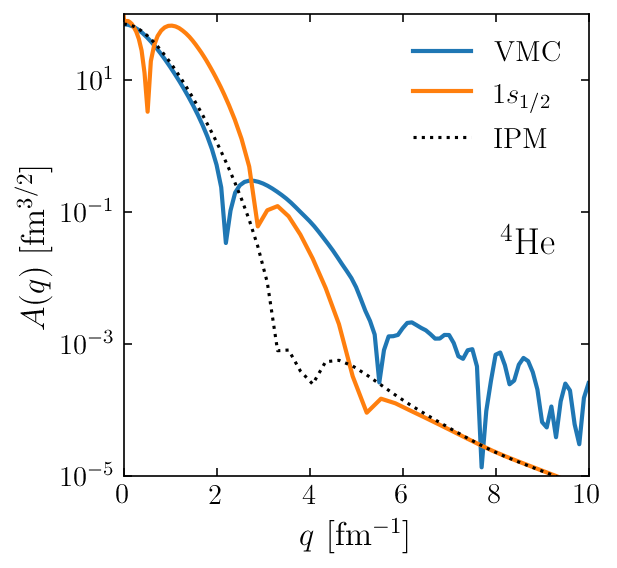

In [13]:
plot_spectroscopic_amplitude(
    so.q_array, so.q_weights, full_overlap_array, alpha,
    ipm_array=ipm_overlap_array, y_limits=(1e-5,1e2), y_scale='log',
    print_sf=True, show_vmc=True, save=True
)